# SERIES TEMPORELLES ou SÉRIES CHRONOLOGIQUES

##### Appication des méthodes des lissages exponentielles sur cinq(5) datasets différents

### **Objectif Possible**
Ces dataset peuvent être utilisé pour analyser les tendances des prix de l'essence sur une période donnée. Nous pouvons effectuer diverses analyses telles que :

**Visualisation des tendances** : Créer des graphiques pour visualiser comment

**Prévision**: Utiliser des techniques de séries chronologiques pour prévoir les futurs.

**Saisonnalité** : Identifier les tendances saisonnières

## **Importer les Bibliothèques Nécessaires**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# **1. Dataset: Gasoline.csv**

Le dataset **Gasoline.csv** contient des données hebdomadaires sur les prix de l'essence aux États-Unis. Voici une brève explication du contenu et de la structure de ce dataset :

### **Structure du Dataset**
**Colonnes** :

***Week*** : La date correspondant à la semaine en cours. Les dates sont au format ***YYYY-MM-DD***.

***Gas Price*** : Le prix de l'essence pour cette semaine, en dollars par gallon.

**Lignes** :

Chaque ligne représente une semaine différente, avec la date de début de la semaine et le prix de l'essence pour cette semaine.
Le dataset contient 652 enregistrements.


## Lire les Données

In [2]:
# Lire le dataset
dataset_1 = pd.read_csv("Gasoline.csv")


In [3]:
# Visualiser les enregistrements
dataset_1.head(-10)

,Week,Gas Price
0,2000-06-04,1.766
1,2000-06-11,1.804
2,2000-06-18,1.845
3,2000-06-25,1.859
4,2000-07-02,1.867
...,...,...
637,2012-08-19,4.118
638,2012-08-26,4.144
639,2012-09-02,4.191
640,2012-09-09,4.219


In [4]:
# Visualiser la taille du dataset
dataset_1.shape

(652, 2)

## **Visualisation des Tendances**

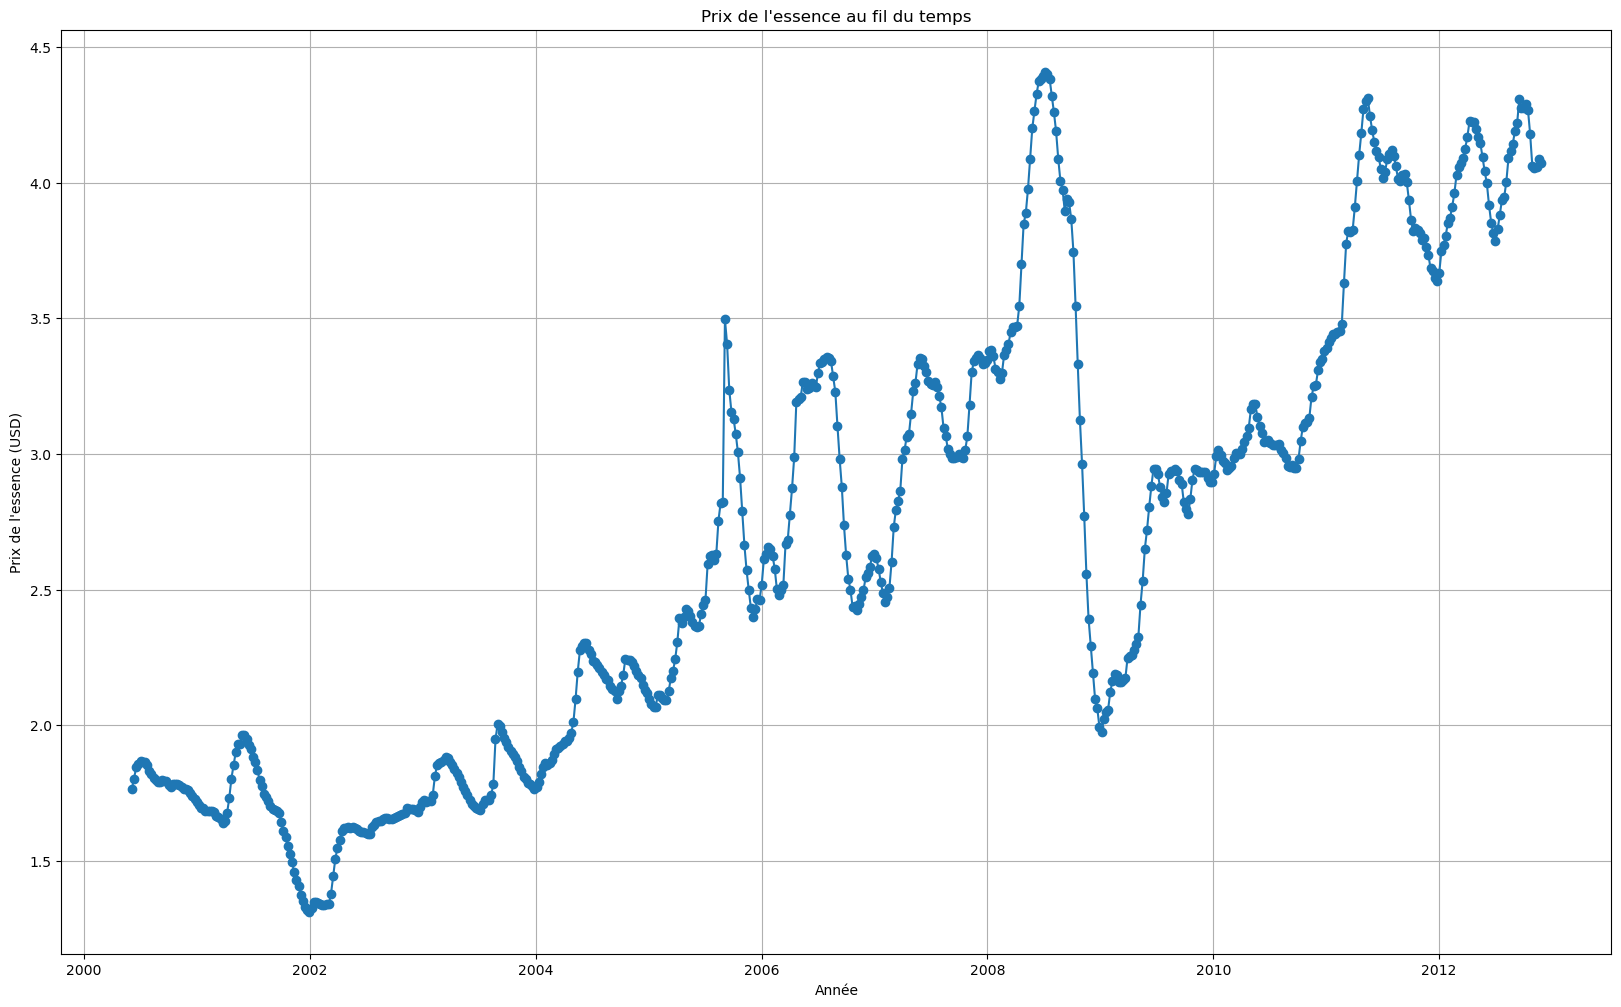

In [5]:
# Convertir la colonne 'Week' en type datetime
dataset_1['Week'] = pd.to_datetime(dataset_1['Week'])

# Tracer les prix de l'essence au fil du temps
plt.figure(figsize=(20, 12))
plt.plot(dataset_1['Week'], dataset_1['Gas Price'], marker='o')
plt.title('Prix de l\'essence au fil du temps')
plt.xlabel('Année')
plt.ylabel('Prix de l\'essence (USD)')
plt.grid(True)
plt.show()

## **Diviser les Données en Entraînement et Test**

In [6]:
train_size = int(len(dataset_1) * 0.9)
train, test = dataset_1[:train_size], dataset_1[train_size:]

## **Fonctions de Lissage Exponentiel**

**Lissage Exponentiel Simple**


In [7]:
def simple_exponential_smoothing(series, alpha):
    result = [series[0]]  # La première valeur lissée est égale à la première valeur réelle
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


**Lissage Exponentiel Double**

In [8]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    level = series[0]
    trend = series[1] - series[0]
    for n in range(1, len(series)):
        last_level, level = level, alpha * series[n] + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


**Lissage Exponentiel de Holt-Winters Non Saisonnière**

In [9]:
def holt_winters_non_seasonal(series, alpha, beta):
    result = [series[0]]
    level = series[0]
    trend = series[1] - series[0]
    for n in range(1, len(series)):
        last_level, level = level, alpha * series[n] + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


**Lissage Exponentiel de Holt-Winters Saisonnière Additif**

In [10]:
def holt_winters_additive(series, alpha, beta, gamma, season_length):
    result = []
    seasonals = [sum(series[:season_length]) / float(season_length)] * season_length
    level = series[0]
    trend = series[1] - series[0]
    for i in range(len(series)):
        if i == 0:
            result.append(series[0])
        elif i < season_length:
            result.append(level + trend + seasonals[i])
            level_last = level
            level = alpha * (series[i] - seasonals[i]) + (1 - alpha) * (level + trend)
            trend = beta * (level - level_last) + (1 - beta) * trend
            seasonals[i] = gamma * (series[i] - level) + (1 - gamma) * seasonals[i]
        else:
            m = i - season_length
            result.append(level + trend + seasonals[m % season_length])
            level_last = level
            level = alpha * (series[i] - seasonals[m % season_length]) + (1 - alpha) * (level + trend)
            trend = beta * (level - level_last) + (1 - beta) * trend
            seasonals[m % season_length] = gamma * (series[i] - level) + (1 - gamma) * seasonals[m % season_length]
    return result


**Lissage Exponentiel de Holt-Winters Saisonnière Multiplicatif**

In [11]:
def holt_winters_multiplicative(series, alpha, beta, gamma, season_length):
    result = []
    seasonals = [sum(series[:season_length]) / float(season_length)] * season_length
    level = series[0]
    trend = series[1] / series[0]
    for i in range(len(series)):
        if i == 0:
            result.append(series[0])
        elif i < season_length:
            result.append((level + trend) * seasonals[i])
            level_last = level
            level = alpha * (series[i] / seasonals[i]) + (1 - alpha) * (level + trend)
            trend = beta * (level - level_last) + (1 - beta) * trend
            seasonals[i] = gamma * (series[i] / level) + (1 - gamma) * seasonals[i]
        else:
            m = i - season_length
            result.append((level + trend) * seasonals[m % season_length])
            level_last = level
            level = alpha * (series[i] / seasonals[m % season_length]) + (1 - alpha) * (level + trend)
            trend = beta * (level - level_last) + (1 - beta) * trend
            seasonals[m % season_length] = gamma * (series[i] / level) + (1 - gamma) * seasonals[m % season_length]
    return result


## **Évaluation des Modèles**

In [12]:
def evaluate_model(train, test, model_func, params):
    errors = []
    for param_set in params:
        predictions = model_func(train, *param_set)
        forecast = predictions[-len(test):]
        error = mean_squared_error(test, forecast)
        errors.append((param_set, error))
    best_params = min(errors, key=lambda x: x[1])[0]
    return best_params

# Paramètres à évaluer
alphas = [0.1, 0.5, 0.9]
betas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]

# Évaluation pour chaque méthode
best_ses_alpha = evaluate_model(train['Gas Price'], test['Gas Price'], simple_exponential_smoothing, [(alpha,) for alpha in alphas])
best_des_params = evaluate_model(train['Gas Price'], test['Gas Price'], double_exponential_smoothing, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_params = evaluate_model(train['Gas Price'], test['Gas Price'], holt_winters_non_seasonal, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_add_params = evaluate_model(train['Gas Price'], test['Gas Price'], holt_winters_additive, [(alpha, beta, gamma, 52) for alpha in alphas for beta in betas for gamma in gammas])
best_hw_mul_params = evaluate_model(train['Gas Price'], test['Gas Price'], holt_winters_multiplicative, [(alpha, beta, gamma, 52) for alpha in alphas for beta in betas for gamma in gammas])


## **Visualisation des Résultats**

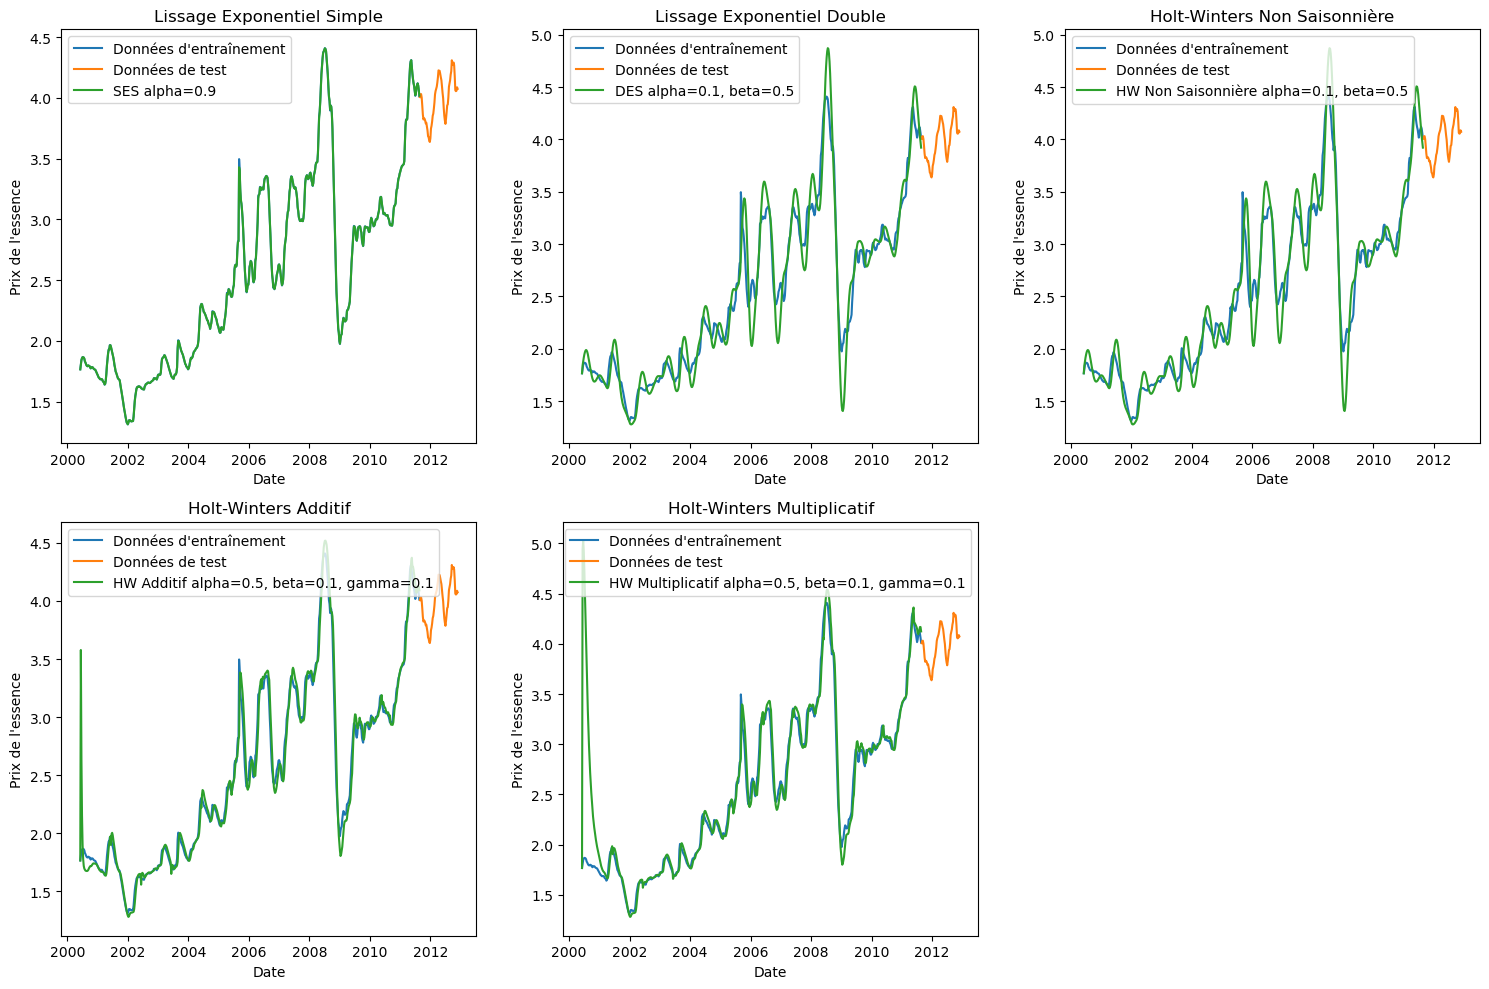

In [13]:
# Générer les graphiques pour chaque méthode
plt.figure(figsize=(15, 10))

# Lissage Exponentiel Simple
plt.subplot(2, 3, 1)
if isinstance(best_ses_alpha, tuple):
    best_ses_alpha = best_ses_alpha[0]  # Extraire le premier élément du tuple si c'est un tuple
best_ses = simple_exponential_smoothing(train['Gas Price'], best_ses_alpha)
plt.plot(train['Week'], train['Gas Price'], label='Données d\'entraînement')
plt.plot(test['Week'], test['Gas Price'], label='Données de test')
plt.plot(train['Week'], best_ses, label=f'SES alpha={best_ses_alpha}')
plt.title('Lissage Exponentiel Simple')
plt.xlabel('Date')
plt.ylabel('Prix de l\'essence')
plt.legend()

# Lissage Exponentiel Double
plt.subplot(2, 3, 2)
best_des = double_exponential_smoothing(train['Gas Price'], best_des_params[0], best_des_params[1])
plt.plot(train['Week'], train['Gas Price'], label='Données d\'entraînement')
plt.plot(test['Week'], test['Gas Price'], label='Données de test')
plt.plot(train['Week'], best_des, label=f'DES alpha={best_des_params[0]}, beta={best_des_params[1]}')
plt.title('Lissage Exponentiel Double')
plt.xlabel('Date')
plt.ylabel('Prix de l\'essence')
plt.legend()

# Holt-Winters Non Saisonnière
plt.subplot(2, 3, 3)
best_hw = holt_winters_non_seasonal(train['Gas Price'], best_hw_params[0], best_hw_params[1])
plt.plot(train['Week'], train['Gas Price'], label='Données d\'entraînement')
plt.plot(test['Week'], test['Gas Price'], label='Données de test')
plt.plot(train['Week'], best_hw, label=f'HW Non Saisonnière alpha={best_hw_params[0]}, beta={best_hw_params[1]}')
plt.title('Holt-Winters Non Saisonnière')
plt.xlabel('Date')
plt.ylabel('Prix de l\'essence')
plt.legend()

# Holt-Winters Saisonnière Additive
plt.subplot(2, 3, 4)
best_hw_add = holt_winters_additive(train['Gas Price'], best_hw_add_params[0], best_hw_add_params[1], best_hw_add_params[2], season_length=52)
plt.plot(train['Week'], train['Gas Price'], label='Données d\'entraînement')
plt.plot(test['Week'], test['Gas Price'], label='Données de test')
plt.plot(train['Week'], best_hw_add, label=f'HW Additif alpha={best_hw_add_params[0]}, beta={best_hw_add_params[1]}, gamma={best_hw_add_params[2]}')
plt.title('Holt-Winters Additif')
plt.xlabel('Date')
plt.ylabel('Prix de l\'essence')
plt.legend()

# Holt-Winters Saisonnière Multiplicative
plt.subplot(2, 3, 5)
best_hw_mul = holt_winters_multiplicative(train['Gas Price'], best_hw_mul_params[0], best_hw_mul_params[1], best_hw_mul_params[2], season_length=52)
plt.plot(train['Week'], train['Gas Price'], label='Données d\'entraînement')
plt.plot(test['Week'], test['Gas Price'], label='Données de test')
plt.plot(train['Week'], best_hw_mul, label=f'HW Multiplicatif alpha={best_hw_mul_params[0]}, beta={best_hw_mul_params[1]}, gamma={best_hw_mul_params[2]}')
plt.title('Holt-Winters Multiplicatif')
plt.xlabel('Date')
plt.ylabel('Prix de l\'essence')
plt.legend()

plt.tight_layout()
plt.show()


# **2. Dataset : Emission.csv**

Le dataset utilisé contient des données sur les émissions de dioxyde de carbone (CO2) sur une période de temps. Voici une explication détaillée du dataset :

**Year**: Cette colonne représente l'année au cours de laquelle les données ont été enregistrées. Chaque année est représentée par une valeur entière.

**Month**: Cette colonne représente le mois au cours duquel les données ont été enregistrées. Chaque mois est représenté par son nom abrégé ou complet.

**CO2 Emission**: Cette colonne représente les émissions de dioxyde de carbone (CO2) enregistrées pour chaque mois et chaque année. Les émissions sont généralement mesurées en tonnes de CO2 ou dans une unité similaire.

Le dataset est structuré de manière à enregistrer les émissions de CO2 mensuelles sur plusieurs années. Il y a un total de 486 entrées dans le dataset, ce qui suggère qu'il couvre une période étendue.

## Lire les Données

In [14]:
dataset_2 = pd.read_csv("Emission.csv")

In [15]:
dataset_2.head(-10)

,Year,Month,CO2 Emission
0,1973,Jan,106.363
1,1973,Feb,101.760
2,1973,Mar,110.553
3,1973,Apr,104.734
4,1973,May,114.897
...,...,...,...
471,2012,Apr,150.602
472,2012,May,157.033
473,2012,Jun,155.372
474,2012,Jul,157.855


In [16]:
dataset_2.shape

(486, 3)

In [17]:
# Combinaison des colonnes 'Year' et 'Month' en une seule colonne de type datetime
dataset_2['Date'] = pd.to_datetime(dataset_2['Year'].astype(str) + '-' + dataset_2['Month'].astype(str) + '-01')

# Trier les données par date
dataset_2 = dataset_2.sort_values(by='Date')

## **Visualisation des Tendances**

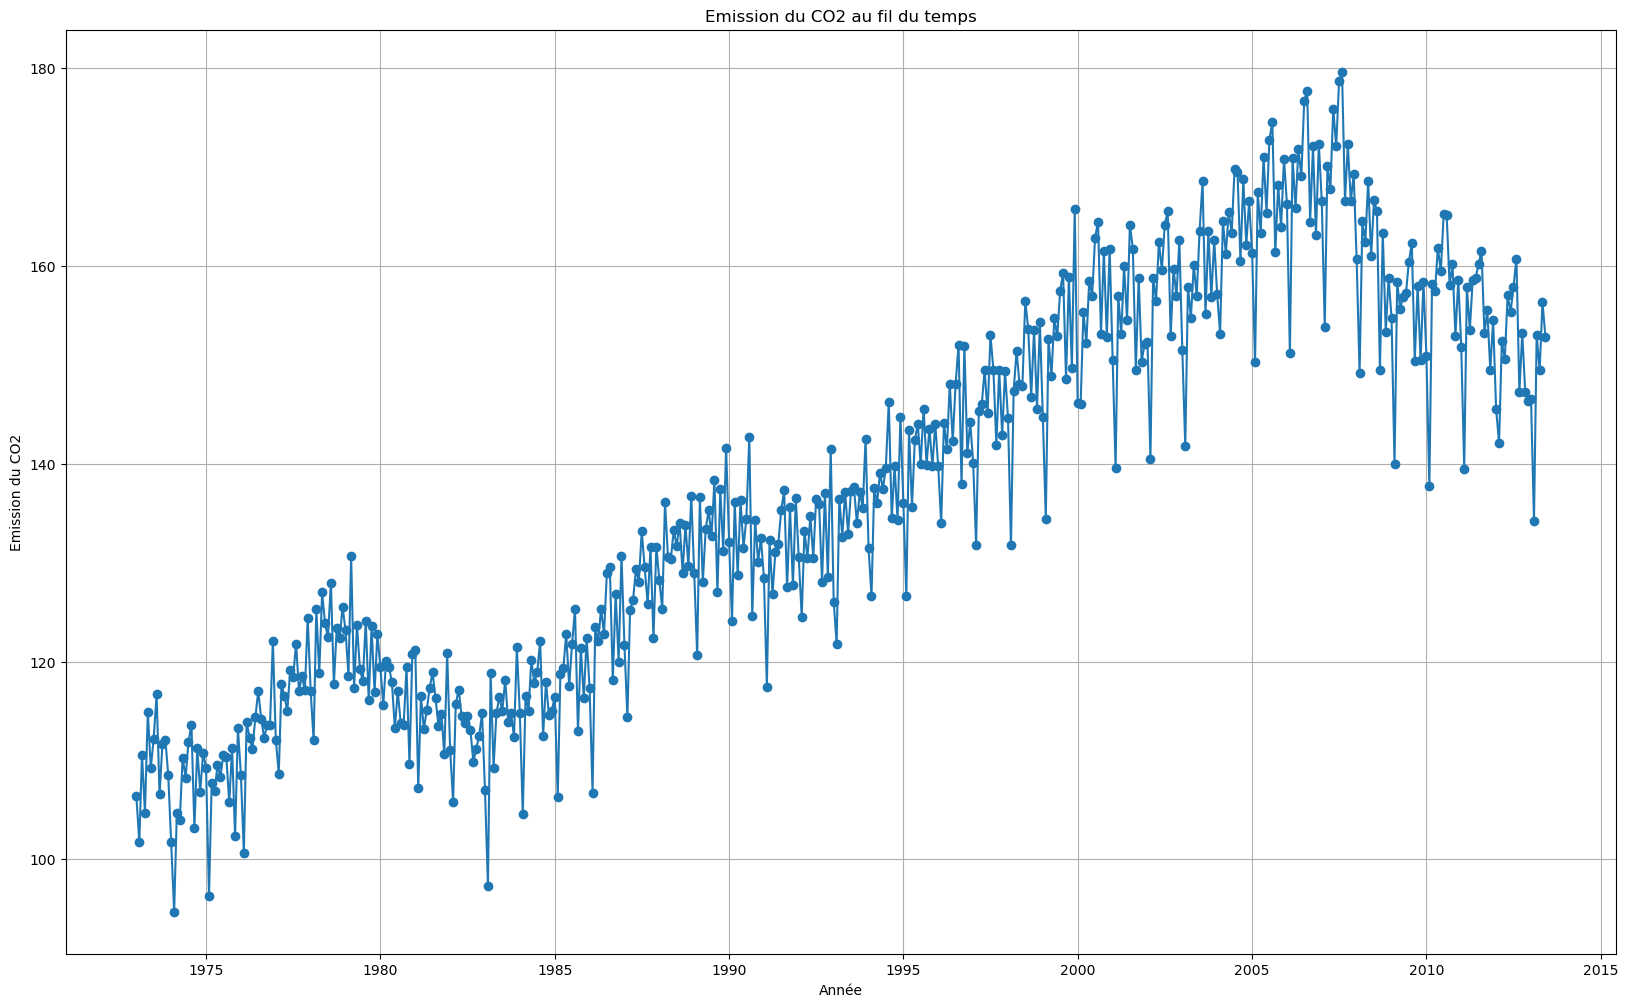

In [18]:
# Convertir la colonne 'Date' en type datetime
dataset_2['Date'] = pd.to_datetime(dataset_2['Date'])

# Tracer les émissions de CO2 au fil du temps
plt.figure(figsize=(20, 12))
plt.plot(dataset_2['Date'], dataset_2['CO2 Emission'], marker='o')
plt.title('Emission du CO2 au fil du temps')
plt.xlabel('Année')
plt.ylabel('Emission du CO2')
plt.grid(True)
plt.show()


In [19]:
# Division des données en ensembles d'entraînement et de test
train_size = int(len(dataset_2) * 0.9)
train, test = dataset_2[:train_size], dataset_2[train_size:]

In [20]:
# # Évaluation pour chaque méthode
best_ses_alpha = evaluate_model(train['CO2 Emission'], test['CO2 Emission'], simple_exponential_smoothing, [(alpha,) for alpha in alphas])
best_des_params = evaluate_model(train['CO2 Emission'], test['CO2 Emission'], double_exponential_smoothing, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_params = evaluate_model(train['CO2 Emission'], test['CO2 Emission'], holt_winters_non_seasonal, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_add_params = evaluate_model(train['CO2 Emission'], test['CO2 Emission'], holt_winters_additive, [(alpha, beta, gamma, 12) for alpha in alphas for beta in betas for gamma in gammas])
best_hw_mul_params = evaluate_model(train['CO2 Emission'], test['CO2 Emission'], holt_winters_multiplicative, [(alpha, beta, gamma, 12) for alpha in alphas for beta in betas for gamma in gammas])


## **Visualisation des Résultats**

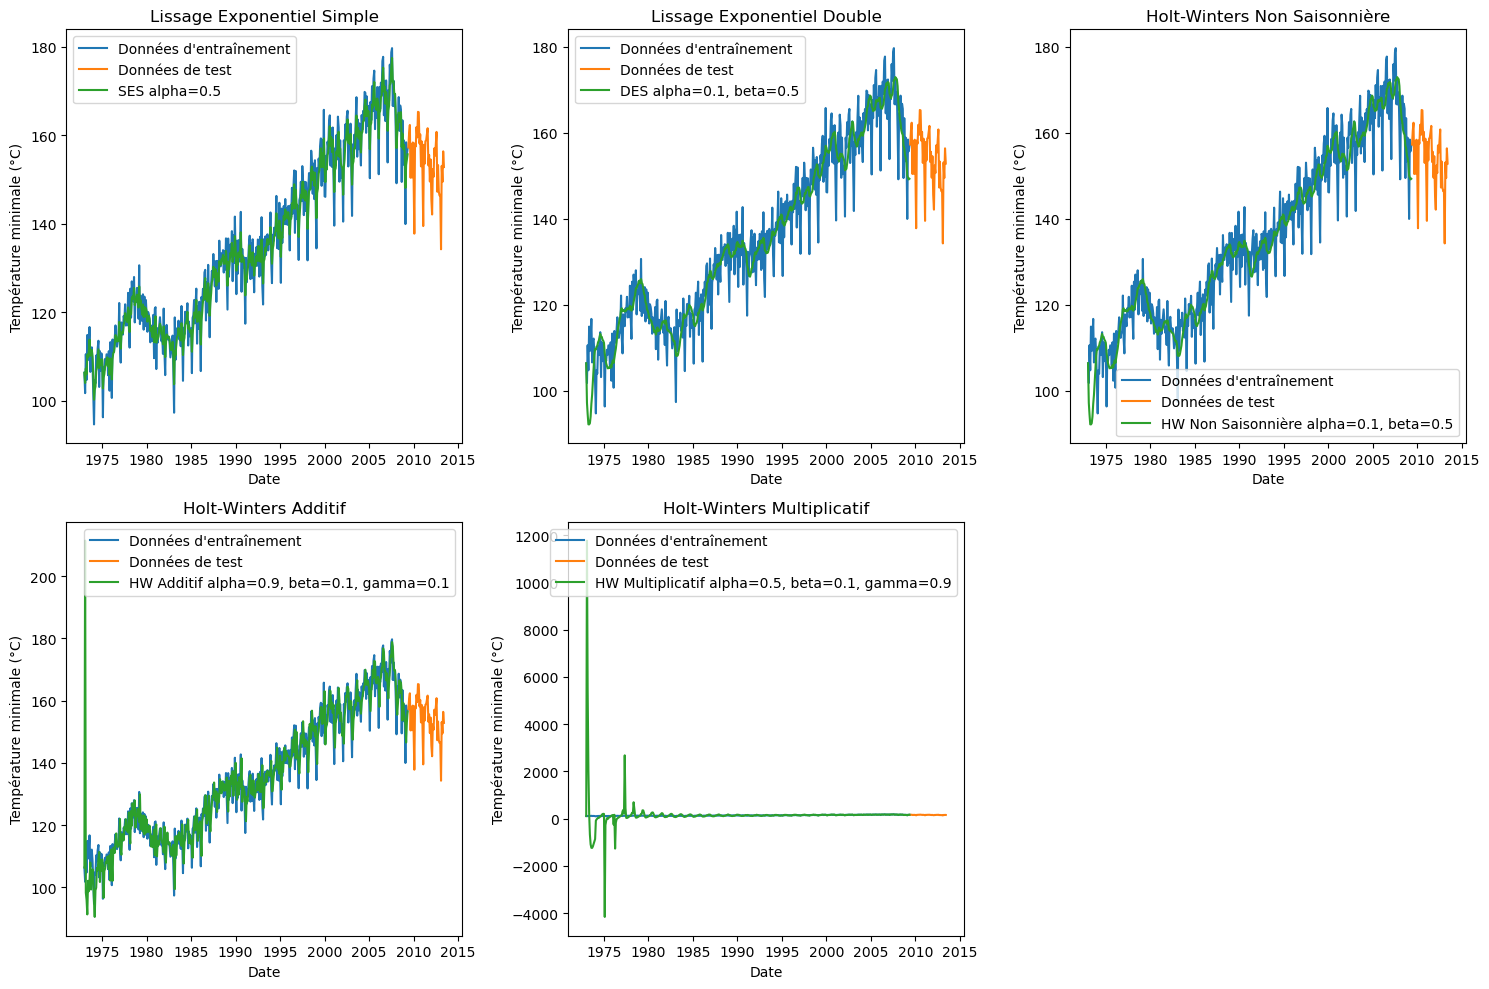

In [21]:
# Générer les graphiques pour chaque méthode
plt.figure(figsize=(15, 10))

# Lissage Exponentiel Simple
plt.subplot(2, 3, 1)
if isinstance(best_ses_alpha, tuple):
    best_ses_alpha = best_ses_alpha[0]  # Extraire le premier élément du tuple si c'est un tuple
best_ses = simple_exponential_smoothing(train['CO2 Emission'], best_ses_alpha)
plt.plot(train['Date'], train['CO2 Emission'], label='Données d\'entraînement')
plt.plot(test['Date'], test['CO2 Emission'], label='Données de test')
plt.plot(train['Date'], best_ses, label=f'SES alpha={best_ses_alpha}')
plt.title('Lissage Exponentiel Simple')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

# Lissage Exponentiel Double
plt.subplot(2, 3, 2)
best_des = double_exponential_smoothing(train['CO2 Emission'], best_des_params[0], best_des_params[1])
plt.plot(train['Date'], train['CO2 Emission'], label='Données d\'entraînement')
plt.plot(test['Date'], test['CO2 Emission'], label='Données de test')
plt.plot(train['Date'], best_des, label=f'DES alpha={best_des_params[0]}, beta={best_des_params[1]}')
plt.title('Lissage Exponentiel Double')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

# Holt-Winters Non Saisonnière
plt.subplot(2, 3, 3)
best_hw = holt_winters_non_seasonal(train['CO2 Emission'], best_hw_params[0], best_hw_params[1])
plt.plot(train['Date'], train['CO2 Emission'], label='Données d\'entraînement')
plt.plot(test['Date'], test['CO2 Emission'], label='Données de test')
plt.plot(train['Date'], best_hw, label=f'HW Non Saisonnière alpha={best_hw_params[0]}, beta={best_hw_params[1]}')
plt.title('Holt-Winters Non Saisonnière')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

# Holt-Winters Saisonnière Additive
plt.subplot(2, 3, 4)
best_hw_add = holt_winters_additive(train['CO2 Emission'], best_hw_add_params[0], best_hw_add_params[1], best_hw_add_params[2], season_length=12)
plt.plot(train['Date'], train['CO2 Emission'], label='Données d\'entraînement')
plt.plot(test['Date'], test['CO2 Emission'], label='Données de test')
plt.plot(train['Date'], best_hw_add, label=f'HW Additif alpha={best_hw_add_params[0]}, beta={best_hw_add_params[1]}, gamma={best_hw_add_params[2]}')
plt.title('Holt-Winters Additif')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

# Holt-Winters Saisonnière Multiplicative
plt.subplot(2, 3, 5)
best_hw_mul = holt_winters_multiplicative(train['CO2 Emission'], best_hw_mul_params[0], best_hw_mul_params[1], best_hw_mul_params[2], season_length=12)
plt.plot(train['Date'], train['CO2 Emission'], label='Données d\'entraînement')
plt.plot(test['Date'], test['CO2 Emission'], label='Données de test')
plt.plot(train['Date'], best_hw_mul, label=f'HW Multiplicatif alpha={best_hw_mul_params[0]}, beta={best_hw_mul_params[1]}, gamma={best_hw_mul_params[2]}')
plt.title('Holt-Winters Multiplicatif')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

plt.tight_layout()
plt.show()


# **3. Dataset : daily-min-temperatures.csv**

Ce dataset contient des données de température minimale quotidienne enregistrées à Melbourne, Australie. Voici une explication des colonnes :

**Date**: Cette colonne représente la date à laquelle la température a été enregistrée. Les dates vont du 1er janvier 1981 au 31 décembre 1990.

**Temp**: Cette colonne représente la température minimale enregistrée pour chaque jour, mesurée en degrés Celsius.

Il y a un total de 3650 entrées dans ce dataset, ce qui correspond à 10 ans de données quotidiennes de température minimale. Chaque ligne représente un jour différent, avec la date et la température minimale enregistrée pour ce jour-là.

## Lire les Données

In [22]:
dataset_3 = pd.read_csv('daily-min-temperatures.csv')

In [23]:
dataset_3.head(-10)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3635,1990-12-17,13.9
3636,1990-12-18,17.2
3637,1990-12-19,14.7
3638,1990-12-20,15.4


In [24]:
dataset_3.shape

(3650, 2)

## **Visualisation des Tendances**

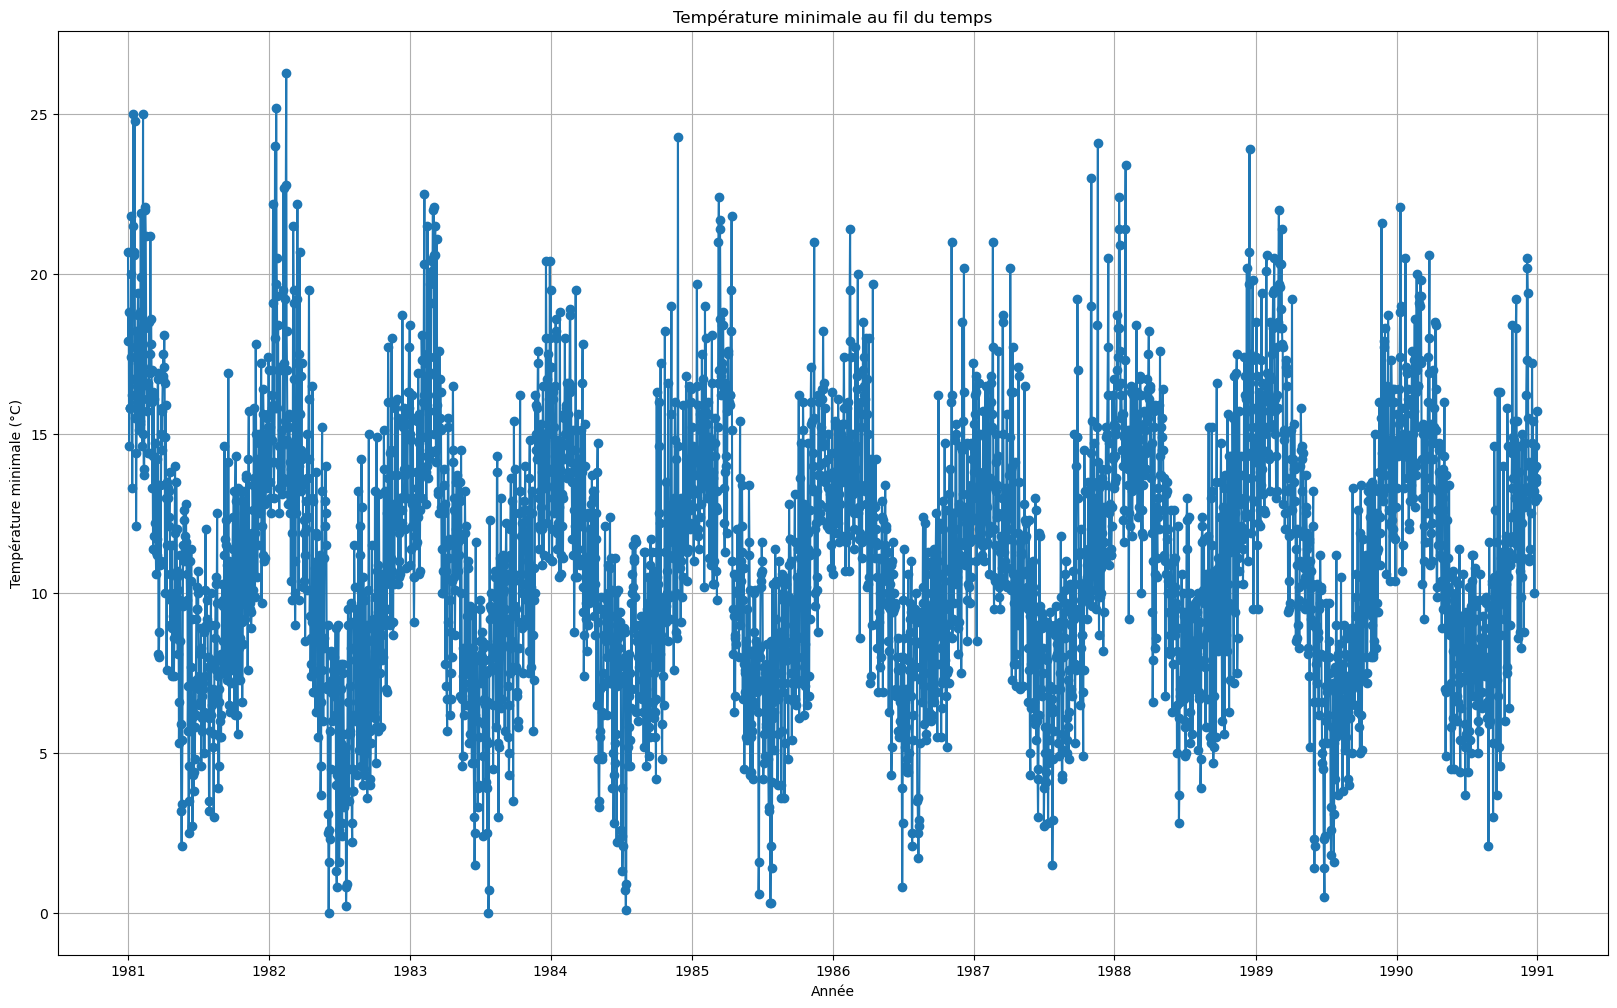

In [25]:
# Convertir la colonne 'Date' en type datetime
dataset_3['Date'] = pd.to_datetime(dataset_3['Date'])

# Tracer les températures minimales au fil du temps
plt.figure(figsize=(20, 12))
plt.plot(dataset_3['Date'], dataset_3['Temp'], marker='o')
plt.title('Température minimale au fil du temps')
plt.xlabel('Année')
plt.ylabel('Température minimale (°C)')
plt.grid(True)
plt.show()


In [26]:
# Division des données en ensembles d'entraînement et de test
train_size = int(len(dataset_3) * 0.9)
train, test = dataset_3[:train_size], dataset_3[train_size:]

In [27]:
# Évaluation pour chaque méthode
best_ses_alpha = evaluate_model(train['Temp'], test['Temp'], simple_exponential_smoothing, [(alpha,) for alpha in alphas])
best_des_params = evaluate_model(train['Temp'], test['Temp'], double_exponential_smoothing, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_params = evaluate_model(train['Temp'], test['Temp'], holt_winters_non_seasonal, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_add_params = evaluate_model(train['Temp'], test['Temp'], holt_winters_additive, [(alpha, beta, gamma, 12) for alpha in alphas for beta in betas for gamma in gammas])
best_hw_mul_params = evaluate_model(train['Temp'], test['Temp'], holt_winters_multiplicative, [(alpha, beta, gamma, 12) for alpha in alphas for beta in betas for gamma in gammas])

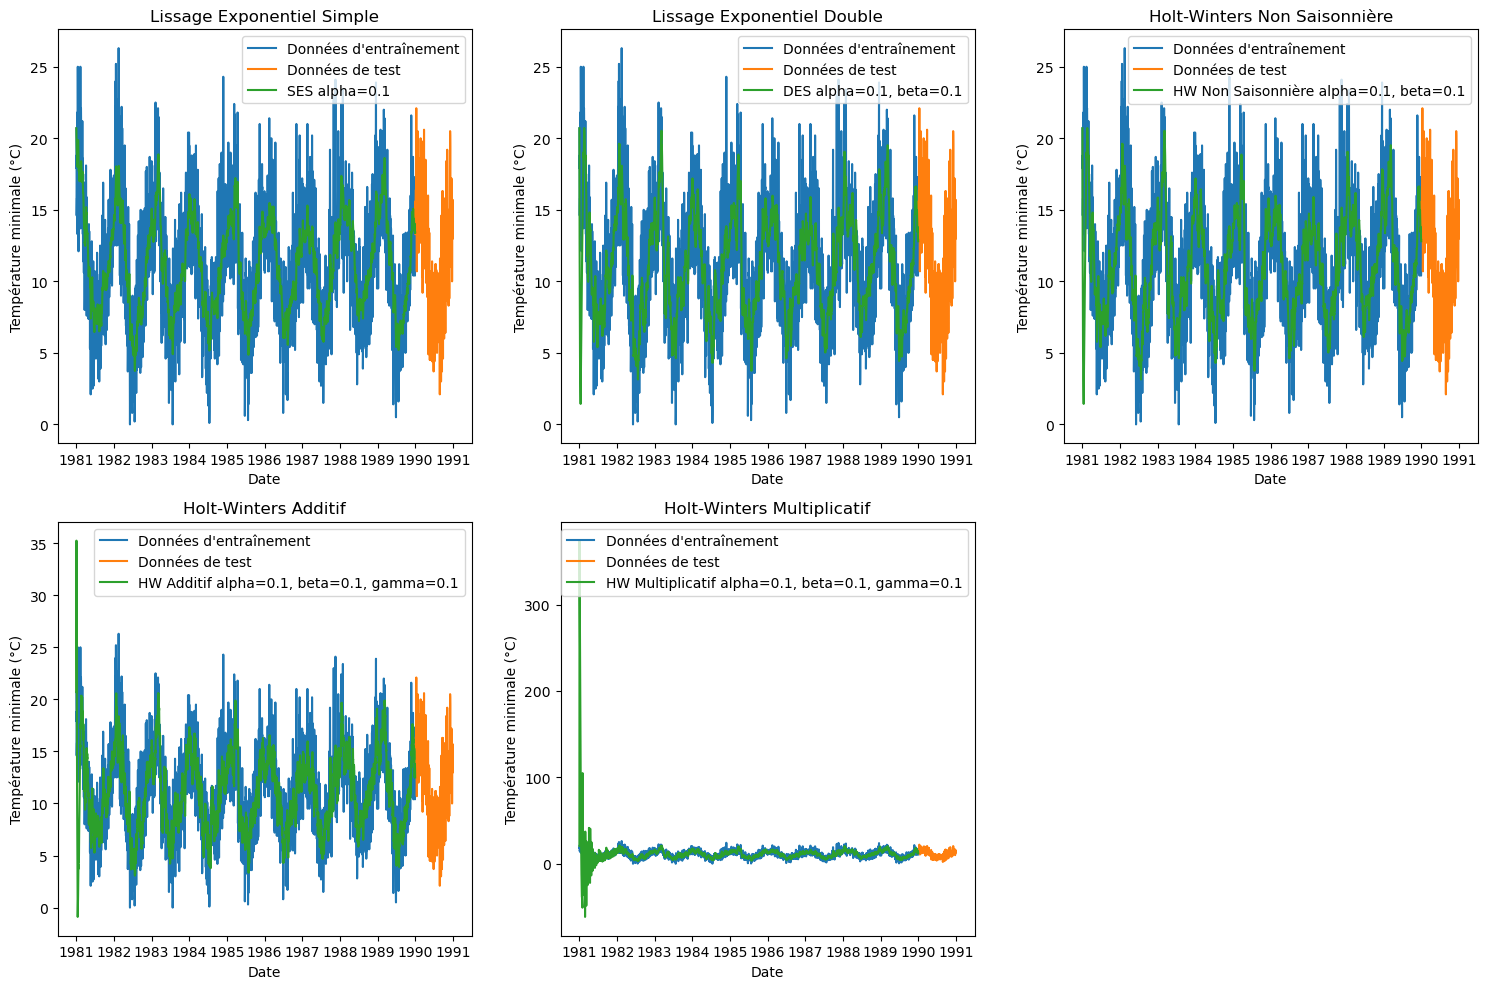

In [28]:
# Générer les graphiques pour chaque méthode
plt.figure(figsize=(15, 10))

# Lissage Exponentiel Simple
plt.subplot(2, 3, 1)
if isinstance(best_ses_alpha, tuple):
    best_ses_alpha = best_ses_alpha[0]  # Extraire le premier élément du tuple si c'est un tuple
best_ses = simple_exponential_smoothing(train['Temp'], best_ses_alpha)
plt.plot(train['Date'], train['Temp'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Temp'], label='Données de test')
plt.plot(train['Date'], best_ses, label=f'SES alpha={best_ses_alpha}')
plt.title('Lissage Exponentiel Simple')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

# Lissage Exponentiel Double
plt.subplot(2, 3, 2)
best_des = double_exponential_smoothing(train['Temp'], best_des_params[0], best_des_params[1])
plt.plot(train['Date'], train['Temp'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Temp'], label='Données de test')
plt.plot(train['Date'], best_des, label=f'DES alpha={best_des_params[0]}, beta={best_des_params[1]}')
plt.title('Lissage Exponentiel Double')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

# Holt-Winters Non Saisonnière
plt.subplot(2, 3, 3)
best_hw = holt_winters_non_seasonal(train['Temp'], best_hw_params[0], best_hw_params[1])
plt.plot(train['Date'], train['Temp'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Temp'], label='Données de test')
plt.plot(train['Date'], best_hw, label=f'HW Non Saisonnière alpha={best_hw_params[0]}, beta={best_hw_params[1]}')
plt.title('Holt-Winters Non Saisonnière')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

# Holt-Winters Saisonnière Additive
plt.subplot(2, 3, 4)
best_hw_add = holt_winters_additive(train['Temp'], best_hw_add_params[0], best_hw_add_params[1], best_hw_add_params[2], season_length=12)
plt.plot(train['Date'], train['Temp'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Temp'], label='Données de test')
plt.plot(train['Date'], best_hw_add, label=f'HW Additif alpha={best_hw_add_params[0]}, beta={best_hw_add_params[1]}, gamma={best_hw_add_params[2]}')
plt.title('Holt-Winters Additif')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

# Holt-Winters Saisonnière Multiplicative
plt.subplot(2, 3, 5)
best_hw_mul = holt_winters_multiplicative(train['Temp'], best_hw_mul_params[0], best_hw_mul_params[1], best_hw_mul_params[2], season_length=12)
plt.plot(train['Date'], train['Temp'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Temp'], label='Données de test')
plt.plot(train['Date'], best_hw_mul, label=f'HW Multiplicatif alpha={best_hw_mul_params[0]}, beta={best_hw_mul_params[1]}, gamma={best_hw_mul_params[2]}')
plt.title('Holt-Winters Multiplicatif')
plt.xlabel('Date')
plt.ylabel('Température minimale (°C)')
plt.legend()

plt.tight_layout()
plt.show()


# **4. Dataset : beer.csv**

Le dataset **beer.csv** représente des données de consommation de bière sur une période allant de janvier 1956 à mai 1964. Voici une explication détaillée :

Chaque ligne du dataset correspond à un mois donné, avec deux colonnes :

**Date** : Cette colonne représente le mois et l'année sous la forme d'une chaîne de caractères, avec le format "AAAA-MM". Par exemple, "1956-01" représente janvier 1956.

**Consommation de bière** : Cette colonne représente la consommation de bière pour le mois correspondant, probablement mesurée dans une unité spécifique (par exemple, litres ou gallons).
Le dataset contient 475 lignes (ou observations) et 2 colonnes.

La consommation de bière varie au fil du temps, comme on peut le voir dans les valeurs de la deuxième colonne.


## Lire les Données

In [29]:
dataset_4 = pd.read_csv('beer.csv')

In [30]:
dataset_4.head(-10)

,1956-01,93.2
0,1956-02,96.0
1,1956-03,95.2
2,1956-04,77.1
3,1956-05,70.9
4,1956-06,64.8
...,...,...
460,1994-06,125.0
461,1994-07,127.0
462,1994-08,143.0
463,1994-09,143.0


In [31]:
# Renommer les colonnes
dataset_4.columns = ['Date', 'Consommation de bière']

In [32]:
dataset_4.head(-10)

,Date,Consommation de bière
0,1956-02,96.0
1,1956-03,95.2
2,1956-04,77.1
3,1956-05,70.9
4,1956-06,64.8
...,...,...
460,1994-06,125.0
461,1994-07,127.0
462,1994-08,143.0
463,1994-09,143.0


In [33]:
dataset_4.shape

(475, 2)

## **Visualisation des Tendances**

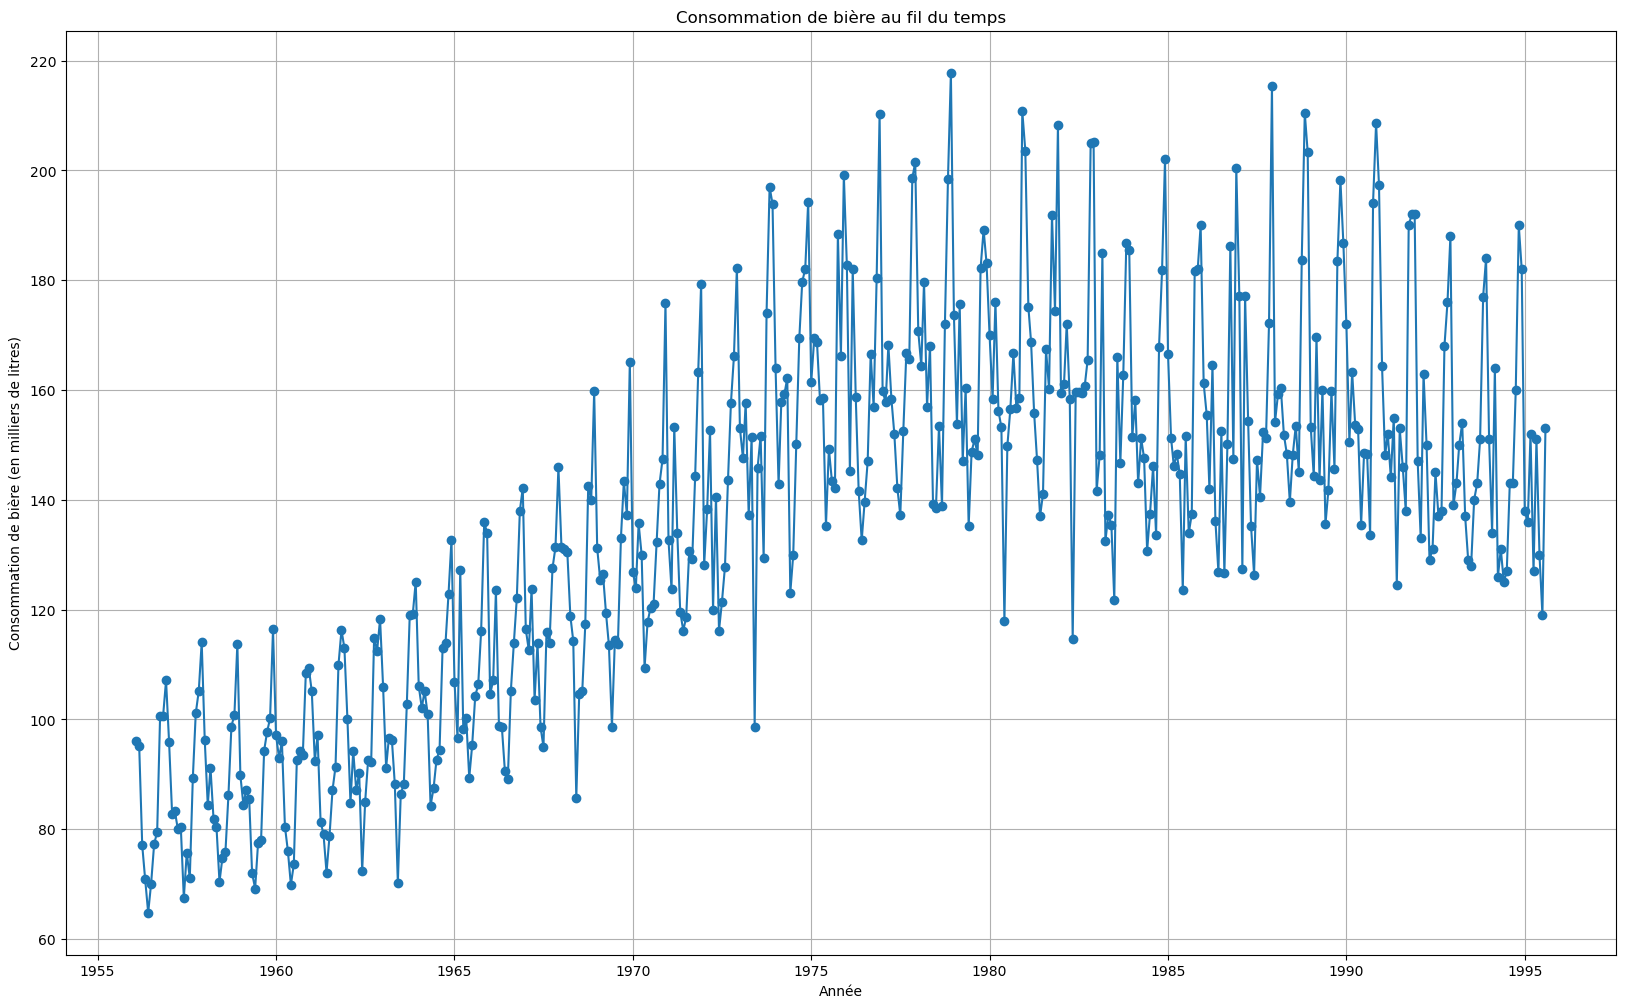

In [34]:
# Convertir la colonne 'Date' en type datetime
dataset_4['Date'] = pd.to_datetime(dataset_4['Date'])

# Tracer la consommation de bière au fil du temps
plt.figure(figsize=(20, 12))
plt.plot(dataset_4['Date'], dataset_4['Consommation de bière'], marker='o')
plt.title('Consommation de bière au fil du temps')
plt.xlabel('Année')
plt.ylabel('Consommation de bière (en milliers de litres)')
plt.grid(True)
plt.show()

In [35]:
# Division des données en ensembles d'entraînement et de test
train_size = int(len(dataset_4) * 0.9)
train, test = dataset_4[:train_size], dataset_4[train_size:]

In [36]:
# Évaluation pour chaque méthode
best_ses_alpha = evaluate_model(train['Consommation de bière'], test['Consommation de bière'], simple_exponential_smoothing, [(alpha,) for alpha in alphas])
best_des_params = evaluate_model(train['Consommation de bière'], test['Consommation de bière'], double_exponential_smoothing, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_params = evaluate_model(train['Consommation de bière'], test['Consommation de bière'], holt_winters_non_seasonal, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_add_params = evaluate_model(train['Consommation de bière'], test['Consommation de bière'], holt_winters_additive, [(alpha, beta, gamma, 12) for alpha in alphas for beta in betas for gamma in gammas])
best_hw_mul_params = evaluate_model(train['Consommation de bière'], test['Consommation de bière'], holt_winters_multiplicative, [(alpha, beta, gamma, 12) for alpha in alphas for beta in betas for gamma in gammas])

## **Visualisation des Résultats**

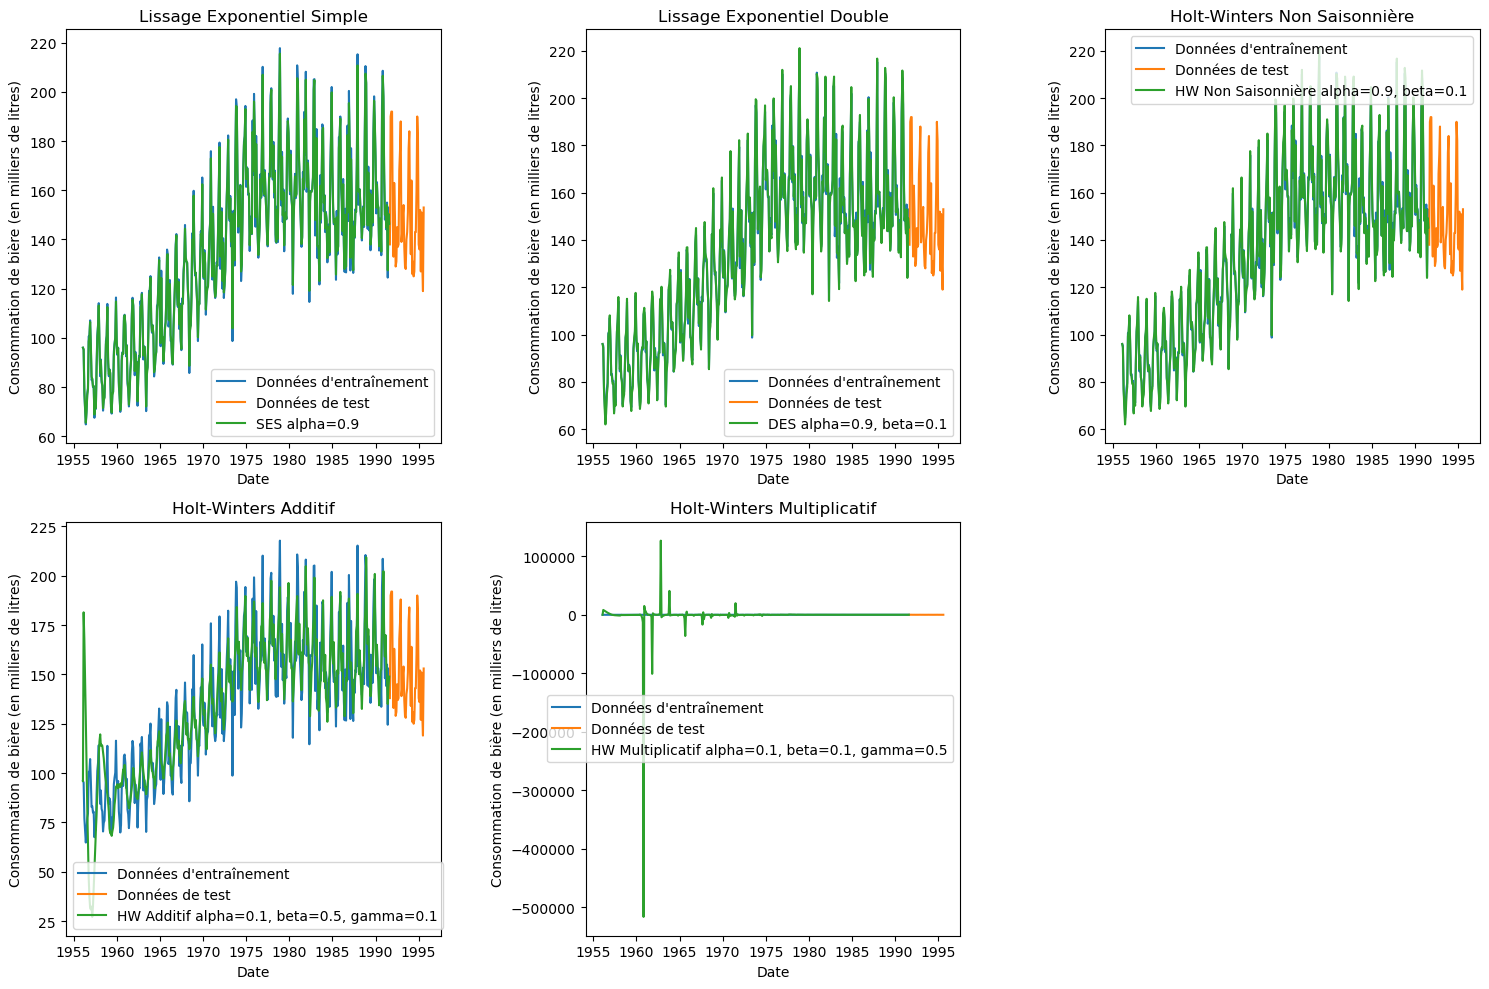

In [37]:
# Générer les graphiques pour chaque méthode
plt.figure(figsize=(15, 10))

# Lissage Exponentiel Simple
plt.subplot(2, 3, 1)
if isinstance(best_ses_alpha, tuple):
    best_ses_alpha = best_ses_alpha[0]  # Extraire le premier élément du tuple si c'est un tuple
best_ses = simple_exponential_smoothing(train['Consommation de bière'], best_ses_alpha)
plt.plot(train['Date'], train['Consommation de bière'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Consommation de bière'], label='Données de test')
plt.plot(train['Date'], best_ses, label=f'SES alpha={best_ses_alpha}')
plt.title('Lissage Exponentiel Simple')
plt.xlabel('Date')
plt.ylabel('Consommation de bière (en milliers de litres)')
plt.legend()

# Lissage Exponentiel Double
plt.subplot(2, 3, 2)
best_des = double_exponential_smoothing(train['Consommation de bière'], best_des_params[0], best_des_params[1])
plt.plot(train['Date'], train['Consommation de bière'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Consommation de bière'], label='Données de test')
plt.plot(train['Date'], best_des, label=f'DES alpha={best_des_params[0]}, beta={best_des_params[1]}')
plt.title('Lissage Exponentiel Double')
plt.xlabel('Date')
plt.ylabel('Consommation de bière (en milliers de litres)')
plt.legend()

# Holt-Winters Non Saisonnière
plt.subplot(2, 3, 3)
best_hw = holt_winters_non_seasonal(train['Consommation de bière'], best_hw_params[0], best_hw_params[1])
plt.plot(train['Date'], train['Consommation de bière'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Consommation de bière'], label='Données de test')
plt.plot(train['Date'], best_hw, label=f'HW Non Saisonnière alpha={best_hw_params[0]}, beta={best_hw_params[1]}')
plt.title('Holt-Winters Non Saisonnière')
plt.xlabel('Date')
plt.ylabel('Consommation de bière (en milliers de litres)')
plt.legend()

# Holt-Winters Saisonnière Additive
plt.subplot(2, 3, 4)
best_hw_add = holt_winters_additive(train['Consommation de bière'], best_hw_add_params[0], best_hw_add_params[1], best_hw_add_params[2], season_length=12)
plt.plot(train['Date'], train['Consommation de bière'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Consommation de bière'], label='Données de test')
plt.plot(train['Date'], best_hw_add, label=f'HW Additif alpha={best_hw_add_params[0]}, beta={best_hw_add_params[1]}, gamma={best_hw_add_params[2]}')
plt.title('Holt-Winters Additif')
plt.xlabel('Date')
plt.ylabel('Consommation de bière (en milliers de litres)')
plt.legend()

# Holt-Winters Saisonnière Multiplicative
plt.subplot(2, 3, 5)
best_hw_mul = holt_winters_multiplicative(train['Consommation de bière'], best_hw_mul_params[0], best_hw_mul_params[1], best_hw_mul_params[2], season_length=12)
plt.plot(train['Date'], train['Consommation de bière'], label='Données d\'entraînement')
plt.plot(test['Date'], test['Consommation de bière'], label='Données de test')
plt.plot(train['Date'], best_hw_mul, label=f'HW Multiplicatif alpha={best_hw_mul_params[0]}, beta={best_hw_mul_params[1]}, gamma={best_hw_mul_params[2]}')
plt.title('Holt-Winters Multiplicatif')
plt.xlabel('Date')
plt.ylabel('Consommation de bière (en milliers de litres)')
plt.legend()

plt.tight_layout()
plt.show()


# **5. Dataset : lynx.csv**

Ce jeu de données représente le nombre de lynx piégés au cours des années dans une région donnée. Voici une interprétation possible des colonnes :

**t** : L'année à laquelle les données ont été enregistrées.
**Lynx** : Le nombre de lynx piégés ou observés au cours de cette année-là.

Le jeu de données comporte 114 lignes et 2 colonnes. Les données s'étendent sur une période allant de 1821 à 1924, ce qui suggère un enregistrement sur une période de plus d'un siècle.

En observant les premières lignes, on peut voir que le nombre de lynx piégés varie considérablement d'une année à l'autre, ce qui pourrait indiquer des fluctuations dans la population de lynx ou des changements dans les pratiques de piégeage ou d'observation au fil du temps.

In [38]:
dataset_5 = pd.read_csv('lynx.csv')

## Lire les Données

In [39]:
dataset_5.head(-10)

,t,Lynx
0,1821,269
1,1822,321
2,1823,585
3,1824,871
4,1825,1475
...,...,...
99,1920,108
100,1921,229
101,1922,399
102,1923,1132


In [40]:
dataset_5.columns = ['Year', 'lynx']

In [41]:
dataset_5.head(-10)

,Year,lynx
0,1821,269
1,1822,321
2,1823,585
3,1824,871
4,1825,1475
...,...,...
99,1920,108
100,1921,229
101,1922,399
102,1923,1132


In [42]:
dataset_5.shape

(114, 2)

## **Visualisation des Tendances**

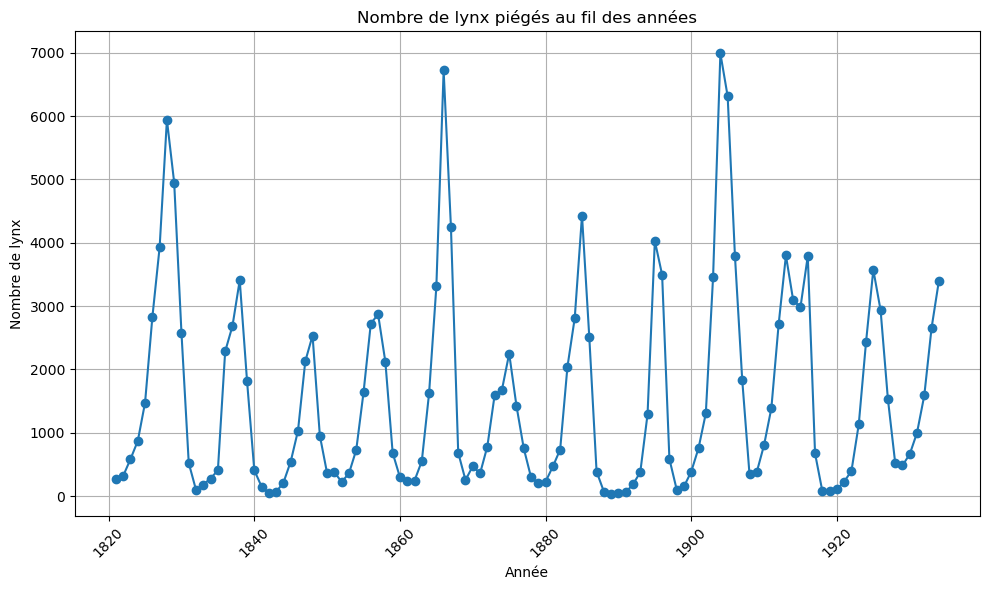

In [43]:
# Convertir la colonne 'Date' en type datetime si nécessaire
# dataset_5['Date'] = pd.to_datetime(dataset_5['Date'])

# Tracer le nombre de lynx au fil des années
plt.figure(figsize=(10, 6))
plt.plot(dataset_5['Year'], dataset_5['lynx'], marker='o', linestyle='-')
plt.title('Nombre de lynx piégés au fil des années')
plt.xlabel('Année')
plt.ylabel('Nombre de lynx')
plt.grid(True)
plt.xticks(rotation=45)  # Pour faire pivoter les étiquettes d'année sur l'axe x
plt.tight_layout()
plt.show()

In [44]:
# Division des données en ensembles d'entraînement et de test
train_size = int(len(dataset_5) * 0.9)
train, test = dataset_5[:train_size], dataset_5[train_size:]

In [45]:
# Évaluation pour chaque méthode
best_ses_alpha = evaluate_model(train['lynx'], test['lynx'], simple_exponential_smoothing, [(alpha,) for alpha in alphas])
best_des_params = evaluate_model(train['lynx'], test['lynx'], double_exponential_smoothing, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_params = evaluate_model(train['lynx'], test['lynx'], holt_winters_non_seasonal, [(alpha, beta) for alpha in alphas for beta in betas])
best_hw_add_params = evaluate_model(train['lynx'], test['lynx'], holt_winters_additive, [(alpha, beta, gamma, 12) for alpha in alphas for beta in betas for gamma in gammas])
best_hw_mul_params = evaluate_model(train['lynx'], test['lynx'], holt_winters_multiplicative, [(alpha, beta, gamma, 12) for alpha in alphas for beta in betas for gamma in gammas])

## **Visualisation des Résultats**

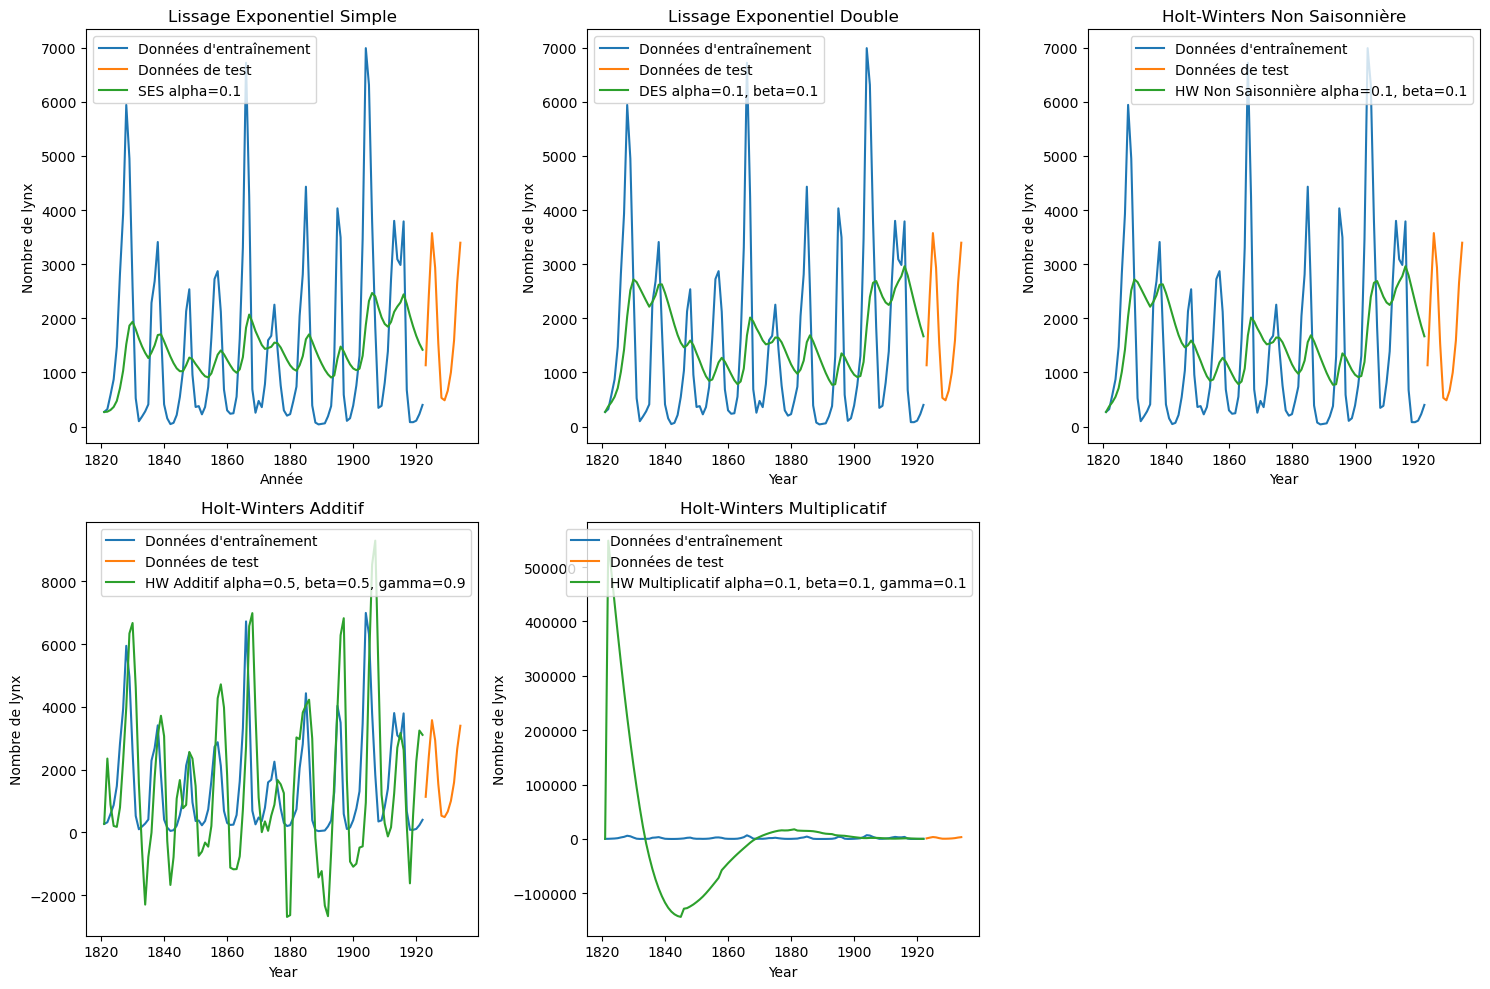

In [46]:
# Générer les graphiques pour chaque méthode
plt.figure(figsize=(15, 10))

# Lissage Exponentiel Simple
plt.subplot(2, 3, 1)
if isinstance(best_ses_alpha, tuple):
    best_ses_alpha = best_ses_alpha[0]  # Extraire le premier élément du tuple si c'est un tuple
best_ses = simple_exponential_smoothing(train['lynx'], best_ses_alpha)
plt.plot(train['Year'], train['lynx'], label='Données d\'entraînement')
plt.plot(test['Year'], test['lynx'], label='Données de test')
plt.plot(train['Year'], best_ses, label=f'SES alpha={best_ses_alpha}')
plt.title('Lissage Exponentiel Simple')
plt.xlabel('Année')
plt.ylabel('Nombre de lynx')
plt.legend()

# Lissage Exponentiel Double
plt.subplot(2, 3, 2)
best_des = double_exponential_smoothing(train['lynx'], best_des_params[0], best_des_params[1])
plt.plot(train['Year'], train['lynx'], label='Données d\'entraînement')
plt.plot(test['Year'], test['lynx'], label='Données de test')
plt.plot(train['Year'], best_des, label=f'DES alpha={best_des_params[0]}, beta={best_des_params[1]}')
plt.title('Lissage Exponentiel Double')
plt.xlabel('Year')
plt.ylabel('Nombre de lynx')
plt.legend()

# Holt-Winters Non Saisonnière
plt.subplot(2, 3, 3)
best_hw = holt_winters_non_seasonal(train['lynx'], best_hw_params[0], best_hw_params[1])
plt.plot(train['Year'], train['lynx'], label='Données d\'entraînement')
plt.plot(test['Year'], test['lynx'], label='Données de test')
plt.plot(train['Year'], best_hw, label=f'HW Non Saisonnière alpha={best_hw_params[0]}, beta={best_hw_params[1]}')
plt.title('Holt-Winters Non Saisonnière')
plt.xlabel('Year')
plt.ylabel('Nombre de lynx')
plt.legend()

# Holt-Winters Saisonnière Additive
plt.subplot(2, 3, 4)
best_hw_add = holt_winters_additive(train['lynx'], best_hw_add_params[0], best_hw_add_params[1], best_hw_add_params[2], season_length=12)
plt.plot(train['Year'], train['lynx'], label='Données d\'entraînement')
plt.plot(test['Year'], test['lynx'], label='Données de test')
plt.plot(train['Year'], best_hw_add, label=f'HW Additif alpha={best_hw_add_params[0]}, beta={best_hw_add_params[1]}, gamma={best_hw_add_params[2]}')
plt.title('Holt-Winters Additif')
plt.xlabel('Year')
plt.ylabel('Nombre de lynx')
plt.legend()

# Holt-Winters Saisonnière Multiplicative
plt.subplot(2, 3, 5)
best_hw_mul = holt_winters_multiplicative(train['lynx'], best_hw_mul_params[0], best_hw_mul_params[1], best_hw_mul_params[2], season_length=12)
plt.plot(train['Year'], train['lynx'], label='Données d\'entraînement')
plt.plot(test['Year'], test['lynx'], label='Données de test')
plt.plot(train['Year'], best_hw_mul, label=f'HW Multiplicatif alpha={best_hw_mul_params[0]}, beta={best_hw_mul_params[1]}, gamma={best_hw_mul_params[2]}')
plt.title('Holt-Winters Multiplicatif')
plt.xlabel('Year')
plt.ylabel('Nombre de lynx')
plt.legend()

plt.tight_layout()
plt.show()
